In [134]:
import matplotlib.pyplot as plt
import numpy as np
import copy

### 生成树，9个顶点，度约束为3

In [106]:
#权重要求与度约束
d=3
weight_matrix=np.array([
    [0,224,224,361,671,300,539,800,943],
    [0,0,200,200,447,283,400,728,762],
    [0,0,0,400,566,447,600,922,949],
    [0,0,0,0,400,200,200,539,583],
    [0,0,0,0,0,600,447,781,510],
    [0,0,0,0,0,0,283,500,707],
    [0,0,0,0,0,0,0,361,424],
    [0,0,0,0,0,0,0,0,500],
    [0,0,0,0,0,0,0,0,0]
    ])

In [107]:
# 解码
def decoding(node,degree,index=0):
    #基于度和节点顺序，通过深度优先搜索建立树
    #返回边为元组的列表
    eages=[]
    de=int(degree[index])
    if de==0 :
        return []
    
    else:
        for i in range(de):
            for j in range(index+1,len(node)):
                if degree[j]>0 and degree[index]>0:
                    eages.append((node[index],node[j]))
                    degree[index]-=1
                    degree[j]-=1
                    sun_eages=decoding(node,degree,j)
                    eages=eages+sun_eages
                    break
        return eages
print(decoding([2., 1., 3., 5., 6., 7., 4., 8., 0.],[3., 3., 2., 2., 2., 1., 1., 1., 1.]))
    

[(2.0, 1.0), (1.0, 3.0), (3.0, 5.0), (5.0, 6.0), (6.0, 7.0), (1.0, 4.0), (2.0, 8.0), (2.0, 0.0)]


In [108]:
#适应度函数
T=np.array([[1,2,0,6,3,8,7,4,5],[1,3,1,2,3,3,1,1,1]])
def fitness_function(T,weight_matrix=weight_matrix,weight_=False):
    s=np.sum(weight_matrix)
    node=T[0].astype('int')
    degree=T[1].astype('int')
    eages=decoding(node,degree)
    sum_weight=0
    for i,j in eages:
        weight=max(weight_matrix[i,j],weight_matrix[j,i])
        sum_weight+=weight
    if weight_:
        return sum_weight
    return -sum_weight
print(fitness_function(T,weight_=True))
    

3017


## 遗传算法

In [148]:
class GA():
    def __init__(self,founction,decoding=decoding,m=12,n=9,eta=2,iterration=20,p=0.2,mutation_ceta=5,d=3):
        self.founction=founction    #适应度评价函数
        self.m=m                    #种群规模
        self.n=n                    #个体编码长度
        self.eta=eta                #仿二进制基因交叉参数
        self.iteration=iterration   #种群迭代次数
        self.group=[]               #种群
        self.fitness=[]             #种群个体适应度
        self.mutation_p=p           #突变概率
        self.mutation_ceta=mutation_ceta #突变方差
        self.decoding_function=decoding #解码器
        self.best_value=-1000000000000
        self.best_weight=[]
        self.history=[]
    
    def initialize_group(self,m=12,n=9,d=3):#MST的种群初始化
        count=0
        while count<m:
            node_one=np.random.choice(9,9,replace=False)
            degree_one=[]
            d_used=0
            for i in range(n):#生成度层
                degree=1
                d_rest=(n-i-1)*(n-1)
                while True:
                    degree=np.random.randint(1,d+1)
                    if degree<=2*(n-1)-d_used-(n-i-1):
                        break
                degree_one.append(degree)
                d_used+=degree
            degree_one=np.array(degree_one)
            entity=[node_one,degree_one]
            test=entity.copy()
            entity=np.array(entity)
            if sum(degree_one)==2*(self.n-1) and self.test_function(test):#并且可以形成树
                count+=1
                #print(entity)
                self.group.append(entity)
        #print(self.group)
        
    
    def fitness_computation(self,sombody=None):#计算种群适应度
        if sombody:
            return self.founction(sombody)
        self.fitness.clear()
        for entity in self.group:
            #print(entity)
            entity=np.array(entity)
            f=self.founction(entity)
            self.fitness.append(f)
        
    def selection_1(self):#使用轮盘赌法进行选择
        sum=np.sum(self.fitness)
        fitness_p=[]#适应度概率
        fitness_p_cumulation=[]#累计函数
        #计算选取概率
        for f in self.fitness:
            fitness_p.append(f/sum)
        #计算积累概率
        p0=0
        for p in fitness_p:
            p0+=p
            fitness_p_cumulation.append(p0)
        #选择操作：
        i=0
        parents=[]
        while i<self.m:
            rp=np.random.uniform(0,1)#产生一个均匀分布的随机数
            for j in range(self.m):
                if fitness_p_cumulation[j]>rp:
                    break
            parents.append(self.group[j])
            i+=1
        return parents
    
    def selection_2(self):#使用比例法进行选择,将种群按大到小划分为3部分
        parents=[]
        
        return parents
    
    def test_function(self,entity):#观察子代是否满足条件
        eages=self.decoding_function(entity[0],entity[1])
        if len(eages)==self.n-1:
            return True
        else:
            return False

    def combination(self,parents):
        i=0
        #self.group.clear()
        children=[]
        while i <self.m:
            x1=np.random.randint(0,self.m)
            x2=np.random.randint(0,self.m)
            entity1=parents[x1]
            entity2=parents[x2]
            #基因交叉，只产生一个子代
            x,y=np.random.choice(self.n,2,replace=False)
            #这两个之间的片段不变
            part=entity1[0][x:y+1]
            child_node=np.zeros(self.n)
            child_degree=np.zeros(self.n)
            for index in range(self.n):
                child_degree[index]=entity1[1][index]
                if index<x or index >y:
                    for index_ in range(self.n):
                        if entity2[0][index_] not in child_node and (entity2[0][index_] not in part):
                            child_node[index]=entity2[0][index_]
                            #print(entity2[0][index])
                else:
                    child_node[index]=entity1[0][index]
            child1=np.array([child_node,child_degree])
            #print(child_degree)
            #print(sum(child_degree))
            if sum(child_degree)==2*(self.n-1):#孩子满足可解码为树的条件
                children.append(child1)
                i+=1
        self.group=children.copy()
        #print('com',self.group)
        

    def mutation(self):
        for entity in self.group:
            p=np.random.uniform(0,1)
            if p<self.mutation_p:
                #使用交换突变：选择两个点，交换两个节点
                i,j=np.random.choice(self.n,2,replace=False)
                #print(i,j)
                t=entity[0][i]
                entity[0][i]=entity[0][j]
                entity[0][j]=t
    
    
    def run(self):
        self.initialize_group()#初始化种群
        self.fitness_computation()#计算种群适应度
        for x in range(self.iteration):
            parents=self.selection_1()#选择父代
            #print(self.group)
            self.combination(parents)#重组算子
            #print(self.group)
            self.mutation()#突变算子
            #print(len(self.group))
            #print(self.group)
            self.fitness_computation()#计算种群适应度
            best=np.max(self.fitness)
            self.history.append(best)
            best_index=np.argmax(self.fitness)
            if self.best_value<best:
                self.best_value=best
                self.best_weight=copy.copy(self.group[best_index])
                #self.best_weight=list(self.group[self.fitness.index(best)]).copy()
            #print("第{:}代，最佳适应度为{:}".format(x,best))
        print("the best one is %s"%self.best_value,self.best_weight)
        print("权重之和为：",-self.best_value)

    def get_best_one(self):
        return self.best_weight

### 重复实验

In [163]:
for i in range(1):
    ga=GA(founction=fitness_function,m=100,iterration=200,p=0.4)
    ga.run()
    T=ga.get_best_one()
    print(decoding(T[0],T[1]))

the best one is -2517 [[2. 1. 3. 6. 5. 4. 8. 7. 0.]
 [1. 3. 3. 2. 1. 2. 2. 1. 1.]]
权重之和为： 2517
[(2.0, 1.0), (1.0, 3.0), (3.0, 6.0), (6.0, 5.0), (3.0, 4.0), (4.0, 8.0), (8.0, 7.0), (1.0, 0.0)]


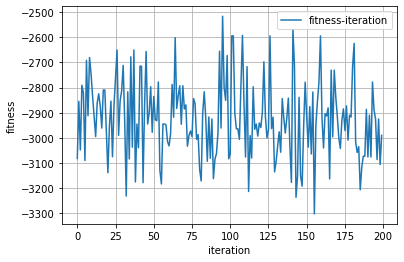

In [164]:
history=ga.history
import matplotlib.pyplot as plt
x=range(len(ga.history))
plt.plot(x,ga.history,label='fitness-iteration')
plt.xlabel('iteration')
plt.ylabel('fitness')
plt.grid('-')
plt.legend()
plt.show()

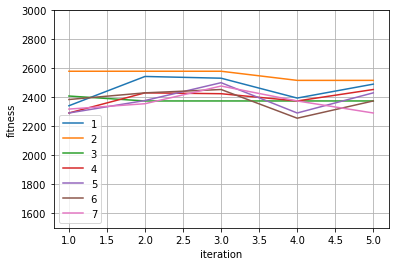

In [168]:
x1=[2342,2544,2532,2395,2491]
x2=[2580,2580,2580,2517,2517]
x3=[2409,2375,2375,2375,2375]
x4=[2292,2431,2425,2375,2454]
x5=[2292,2378,2501,2292,2431]
x6=[2385,2431,2454,2256,2375]
x7=[2319,2356,2478,2375,2292]
x=[1,2,3,4,5]
y=[x1,x2,x3,x4,x5,x6,x7]
for i in range(7):
    plt.plot(x,y[i],label=str(i+1))
plt.xlabel('iteration')
plt.ylabel('fitness')
plt.grid('-')
plt.ylim(1500,3000)
plt.legend()
plt.show()